In [24]:
from utils.utilities import get_engine
import pandas as pd
import numpy as np
from scipy.stats import norm
from datetime import datetime, timedelta

In [25]:
STOCK_CODES = ["SYI", "NEC", "IFT", 'JBH']

In [26]:
day_interval = 365 # one year of transaction
engine = get_engine(country = 'AU')
end_date = datetime.today().date()
start_date = end_date - timedelta(days = day_interval)

In [27]:
# query all data of the stock code since the first transaction date
query = f"""
    SELECT 
        date,
        stock_code,
        close
    FROM transaction
    WHERE
        date >= DATE '{start_date}'
        AND
        date <= DATE '{end_date}'
        AND
        stock_code IN {tuple(STOCK_CODES)}
    ORDER BY date
"""
df = pd.read_sql_query(query, engine).set_index('date')
df = df.dropna()
df.head()

,stock_code,close
date,,
2023-01-10,JBH,41.985283
2023-01-10,IFT,7.760144
2023-01-10,SYI,26.349932
2023-01-10,NEC,1.761478
2023-01-11,NEC,1.766200


In [28]:
# preprocess data
result = None
for stock_code in STOCK_CODES:
    stock_prices = df[df['stock_code'] == stock_code].rename(columns = {'close' : stock_code})[stock_code].to_frame()
    if result is None:
        result = stock_prices
    else:
        result = result.merge(stock_prices, on = 'date')
df = result
df.head()

,SYI,NEC,IFT,JBH
date,,,,
2023-01-10,26.349932,1.761478,7.760144,41.985283
2023-01-11,26.663395,1.766200,7.750334,43.030247
2023-01-12,26.834379,1.803980,7.730712,42.479774
2023-01-13,27.014854,1.813425,7.858250,42.489109
2023-01-16,27.290323,1.846482,7.809197,43.944595


<Axes: title={'center': 'daily percentage returns'}, xlabel='date'>

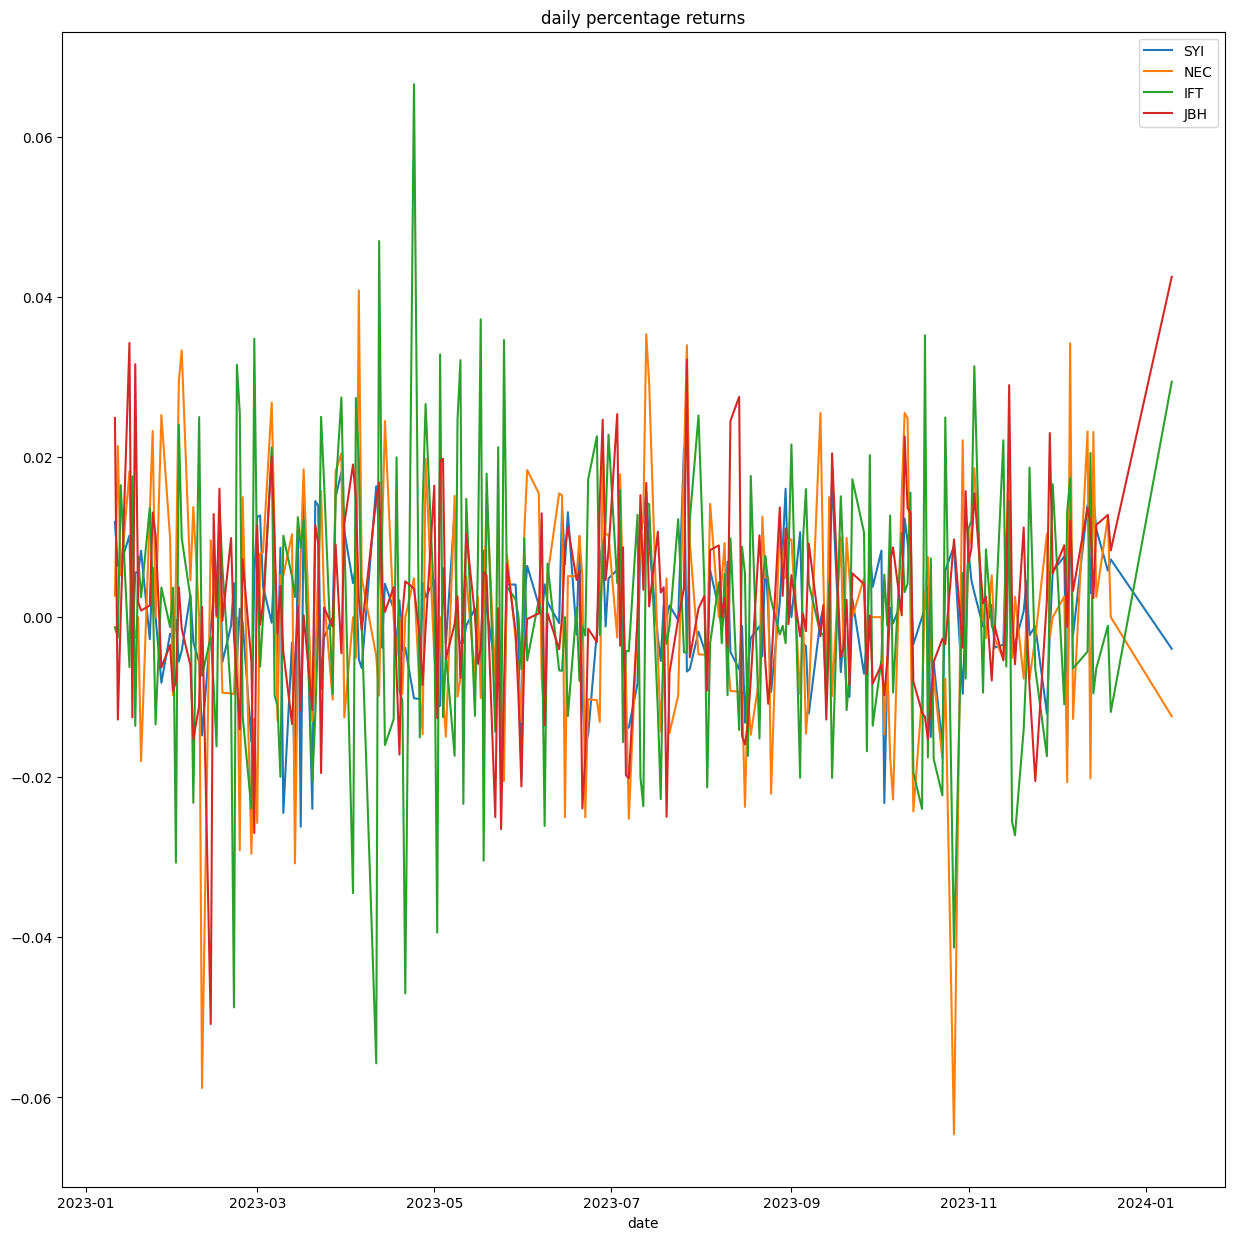

In [29]:
# Risk analysis
pct_change = df.pct_change().dropna()
pct_change.plot(figsize = (15,15), title = 'daily percentage returns')

<Axes: title={'center': 'Portfolio Risk'}>

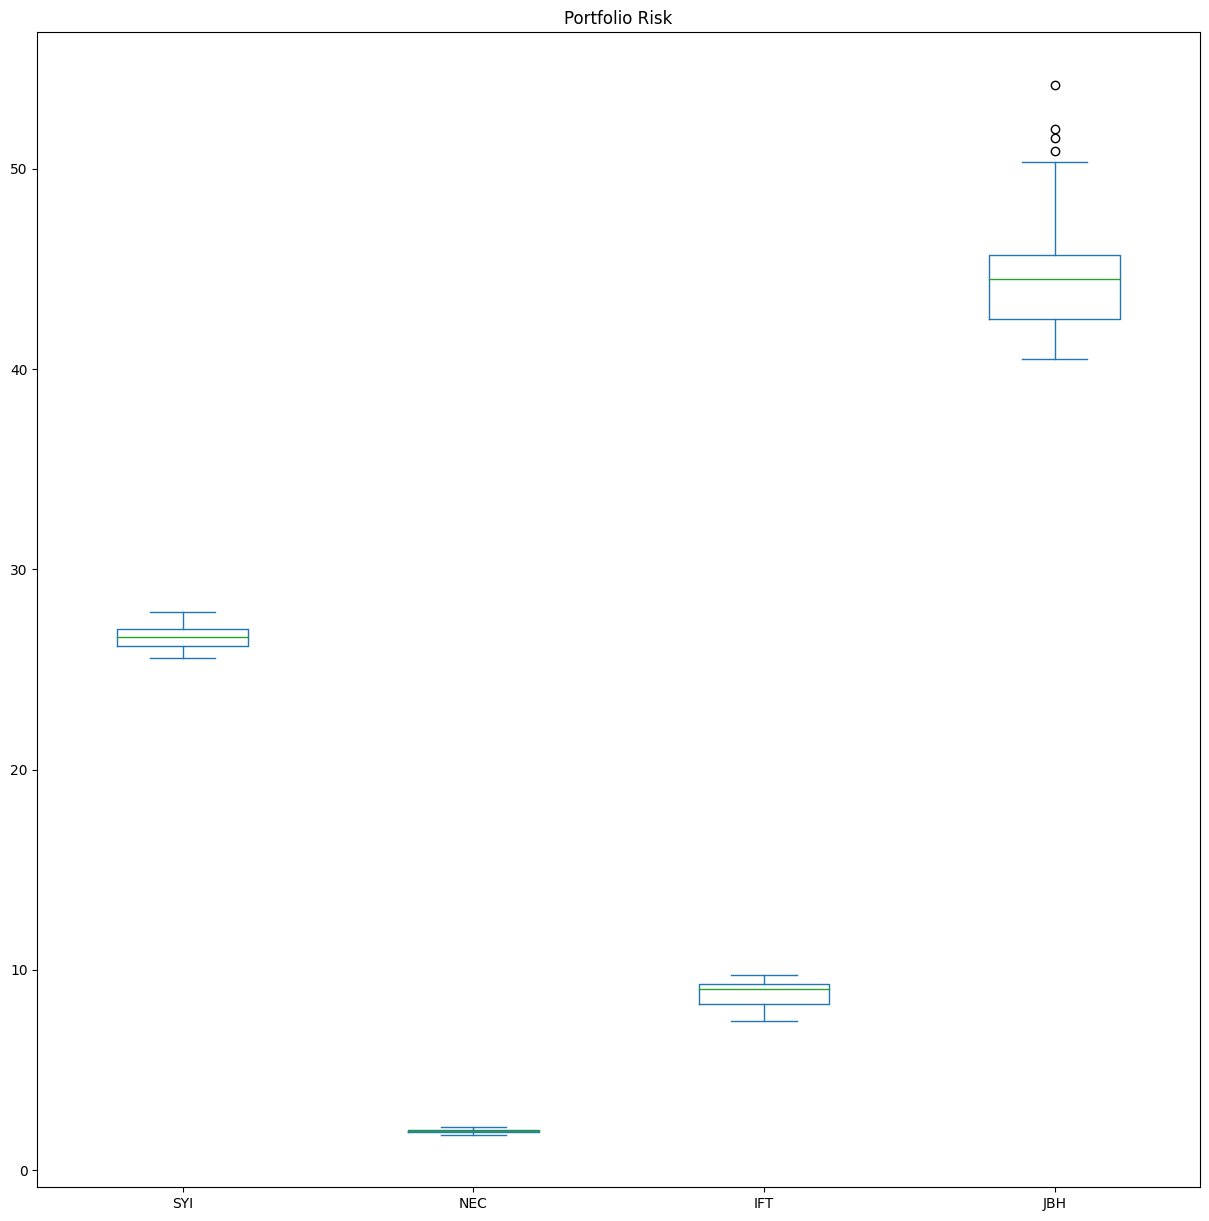

In [30]:
# Box plot to visually show risk
df.plot.box(figsize=(15, 15), title="Portfolio Risk")

<Axes: title={'center': 'Cumulative Returns'}, xlabel='date'>

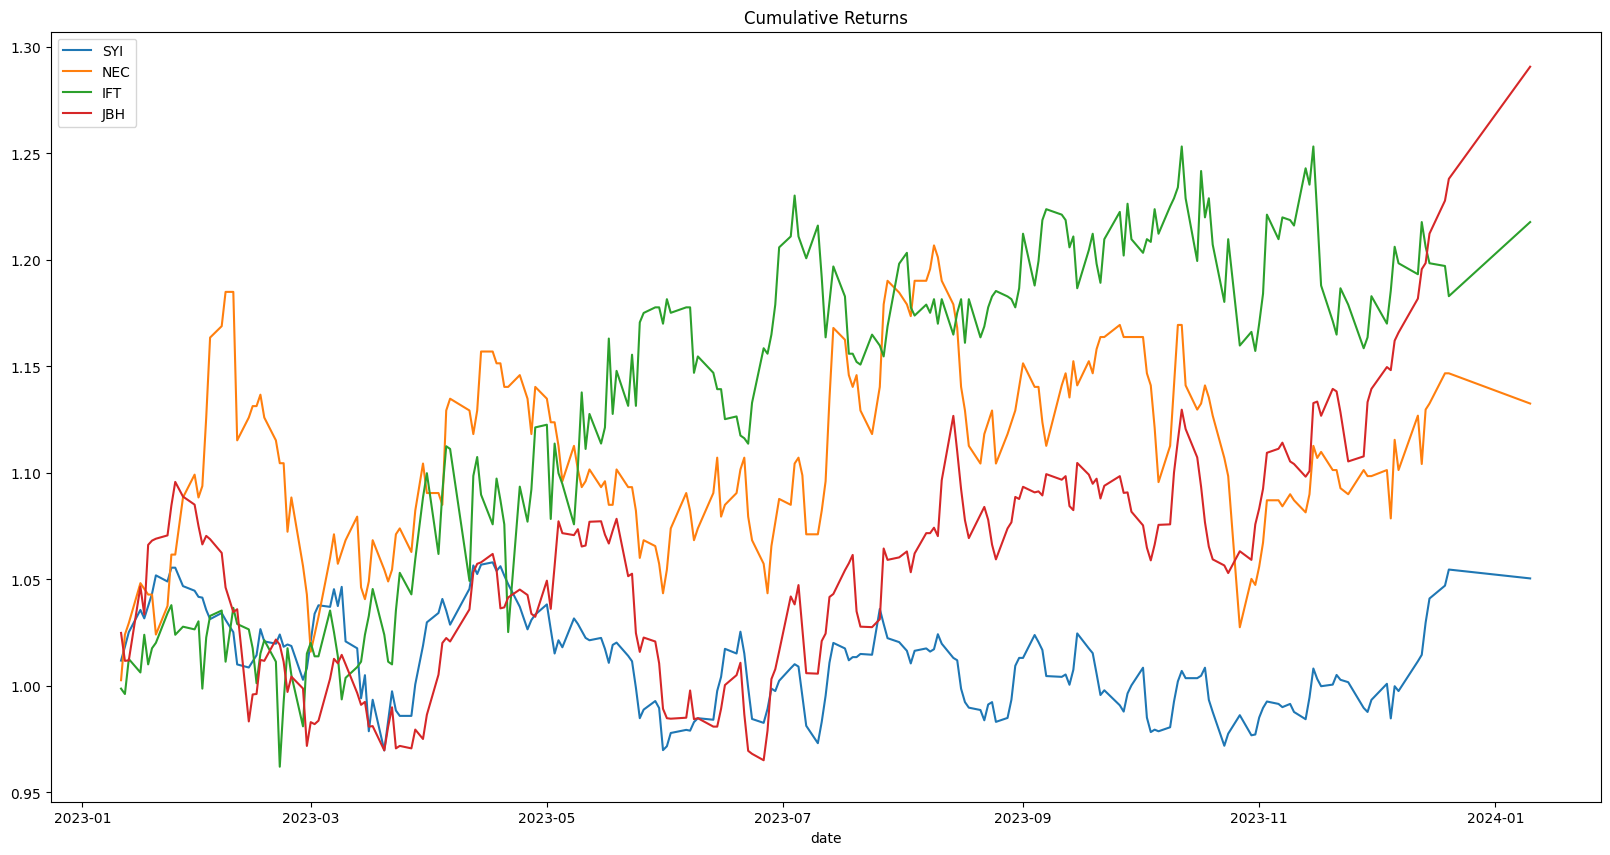

In [31]:
# Calculate cumulative returns
cumulative_returns = (1 + pct_change).cumprod()
# Plot cumulative returns
cumulative_returns.plot(figsize=(20, 10), title="Cumulative Returns")

<Axes: title={'center': '30 Day Rolling Standard Deviation'}, xlabel='date'>

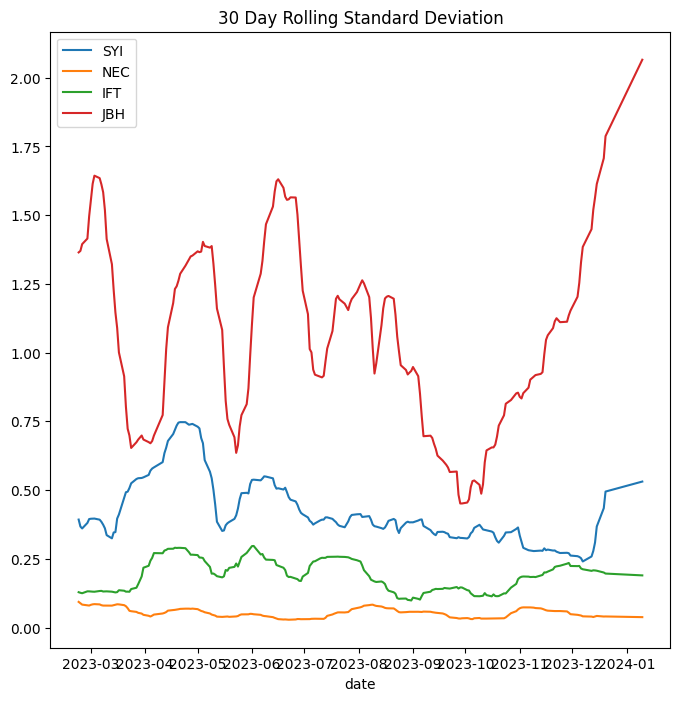

In [32]:
# rolling 30 day windows of volatility
df.rolling(window=30).std().plot(figsize=(8, 8), title="30 Day Rolling Standard Deviation")

In [33]:
# Get correlation between these stocks
df.corr()

,SYI,NEC,IFT,JBH
SYI,1.000000,0.202339,-0.464494,0.140342
NEC,0.202339,1.000000,0.410853,0.409735
IFT,-0.464494,0.410853,1.000000,0.525582
JBH,0.140342,0.409735,0.525582,1.000000


In [34]:
# get confidence interval of the stock
for stock_code in STOCK_CODES:
    log_return = np.log(df[stock_code].shift(-1) - np.log(df[stock_code]))
    sample_size = len(log_return)
    sample_mean = log_return.mean()
    sample_std = log_return.std(ddof = 1) / (sample_size ** 0.5)
    # left and right quantile
    z_left = norm.ppf(0.05)
    z_right = norm.ppf(0.95)

    # upper and lower bound
    interval_left = sample_mean + z_left * sample_std
    interval_right = sample_mean + z_right * sample_std

    print(f"Confidence interval of daily return of {stock_code} is: ({round(interval_left,2)},AUD {round(interval_right, 2)})")

Confidence interval of daily return of SYI is: (3.15,AUD 3.15)
Confidence interval of daily return of NEC is: (0.25,AUD 0.25)
Confidence interval of daily return of IFT is: (1.88,AUD 1.9)
Confidence interval of daily return of JBH is: (3.7,AUD 3.71)
